In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

In [2]:
DATASET_DIRECTORY = '/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023/'

In [3]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
training_sets = df_sets[:int(len(df_sets)*.67)]
test_sets = df_sets[int(len(df_sets)*.67):]

In [4]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

In [5]:
from sklearn.preprocessing import LabelEncoder

ML_models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, class_weight='balanced', random_state=42),
    XGBClassifier(n_estimators=50, max_depth=5, reg_alpha=1, reg_lambda=1, subsample=0.8, random_state=42)
]

# Define the names of your ML models
ML_names = [
    "Logistic Regression",
    "Random Forest",
    "XG BOOST"
]
correlation_matrices=[]
for train_set in tqdm(training_sets):
        d = pd.read_csv(DATASET_DIRECTORY + train_set)
        d[X_columns] = scaler.fit_transform(d[X_columns])
        label_encoder = LabelEncoder()
        d[y_column] = label_encoder.fit_transform(d[y_column].values)
        X_train = d[X_columns].values
        y_train = d[y_column].values
        for model in ML_models:
        # Fit the model with class weights
            model.fit(X_train, y_train)
            correlation_matrices.append(d[X_columns].corrwith(d[y_column]))
        del d


100%|██████████| 113/113 [4:20:28<00:00, 138.30s/it]


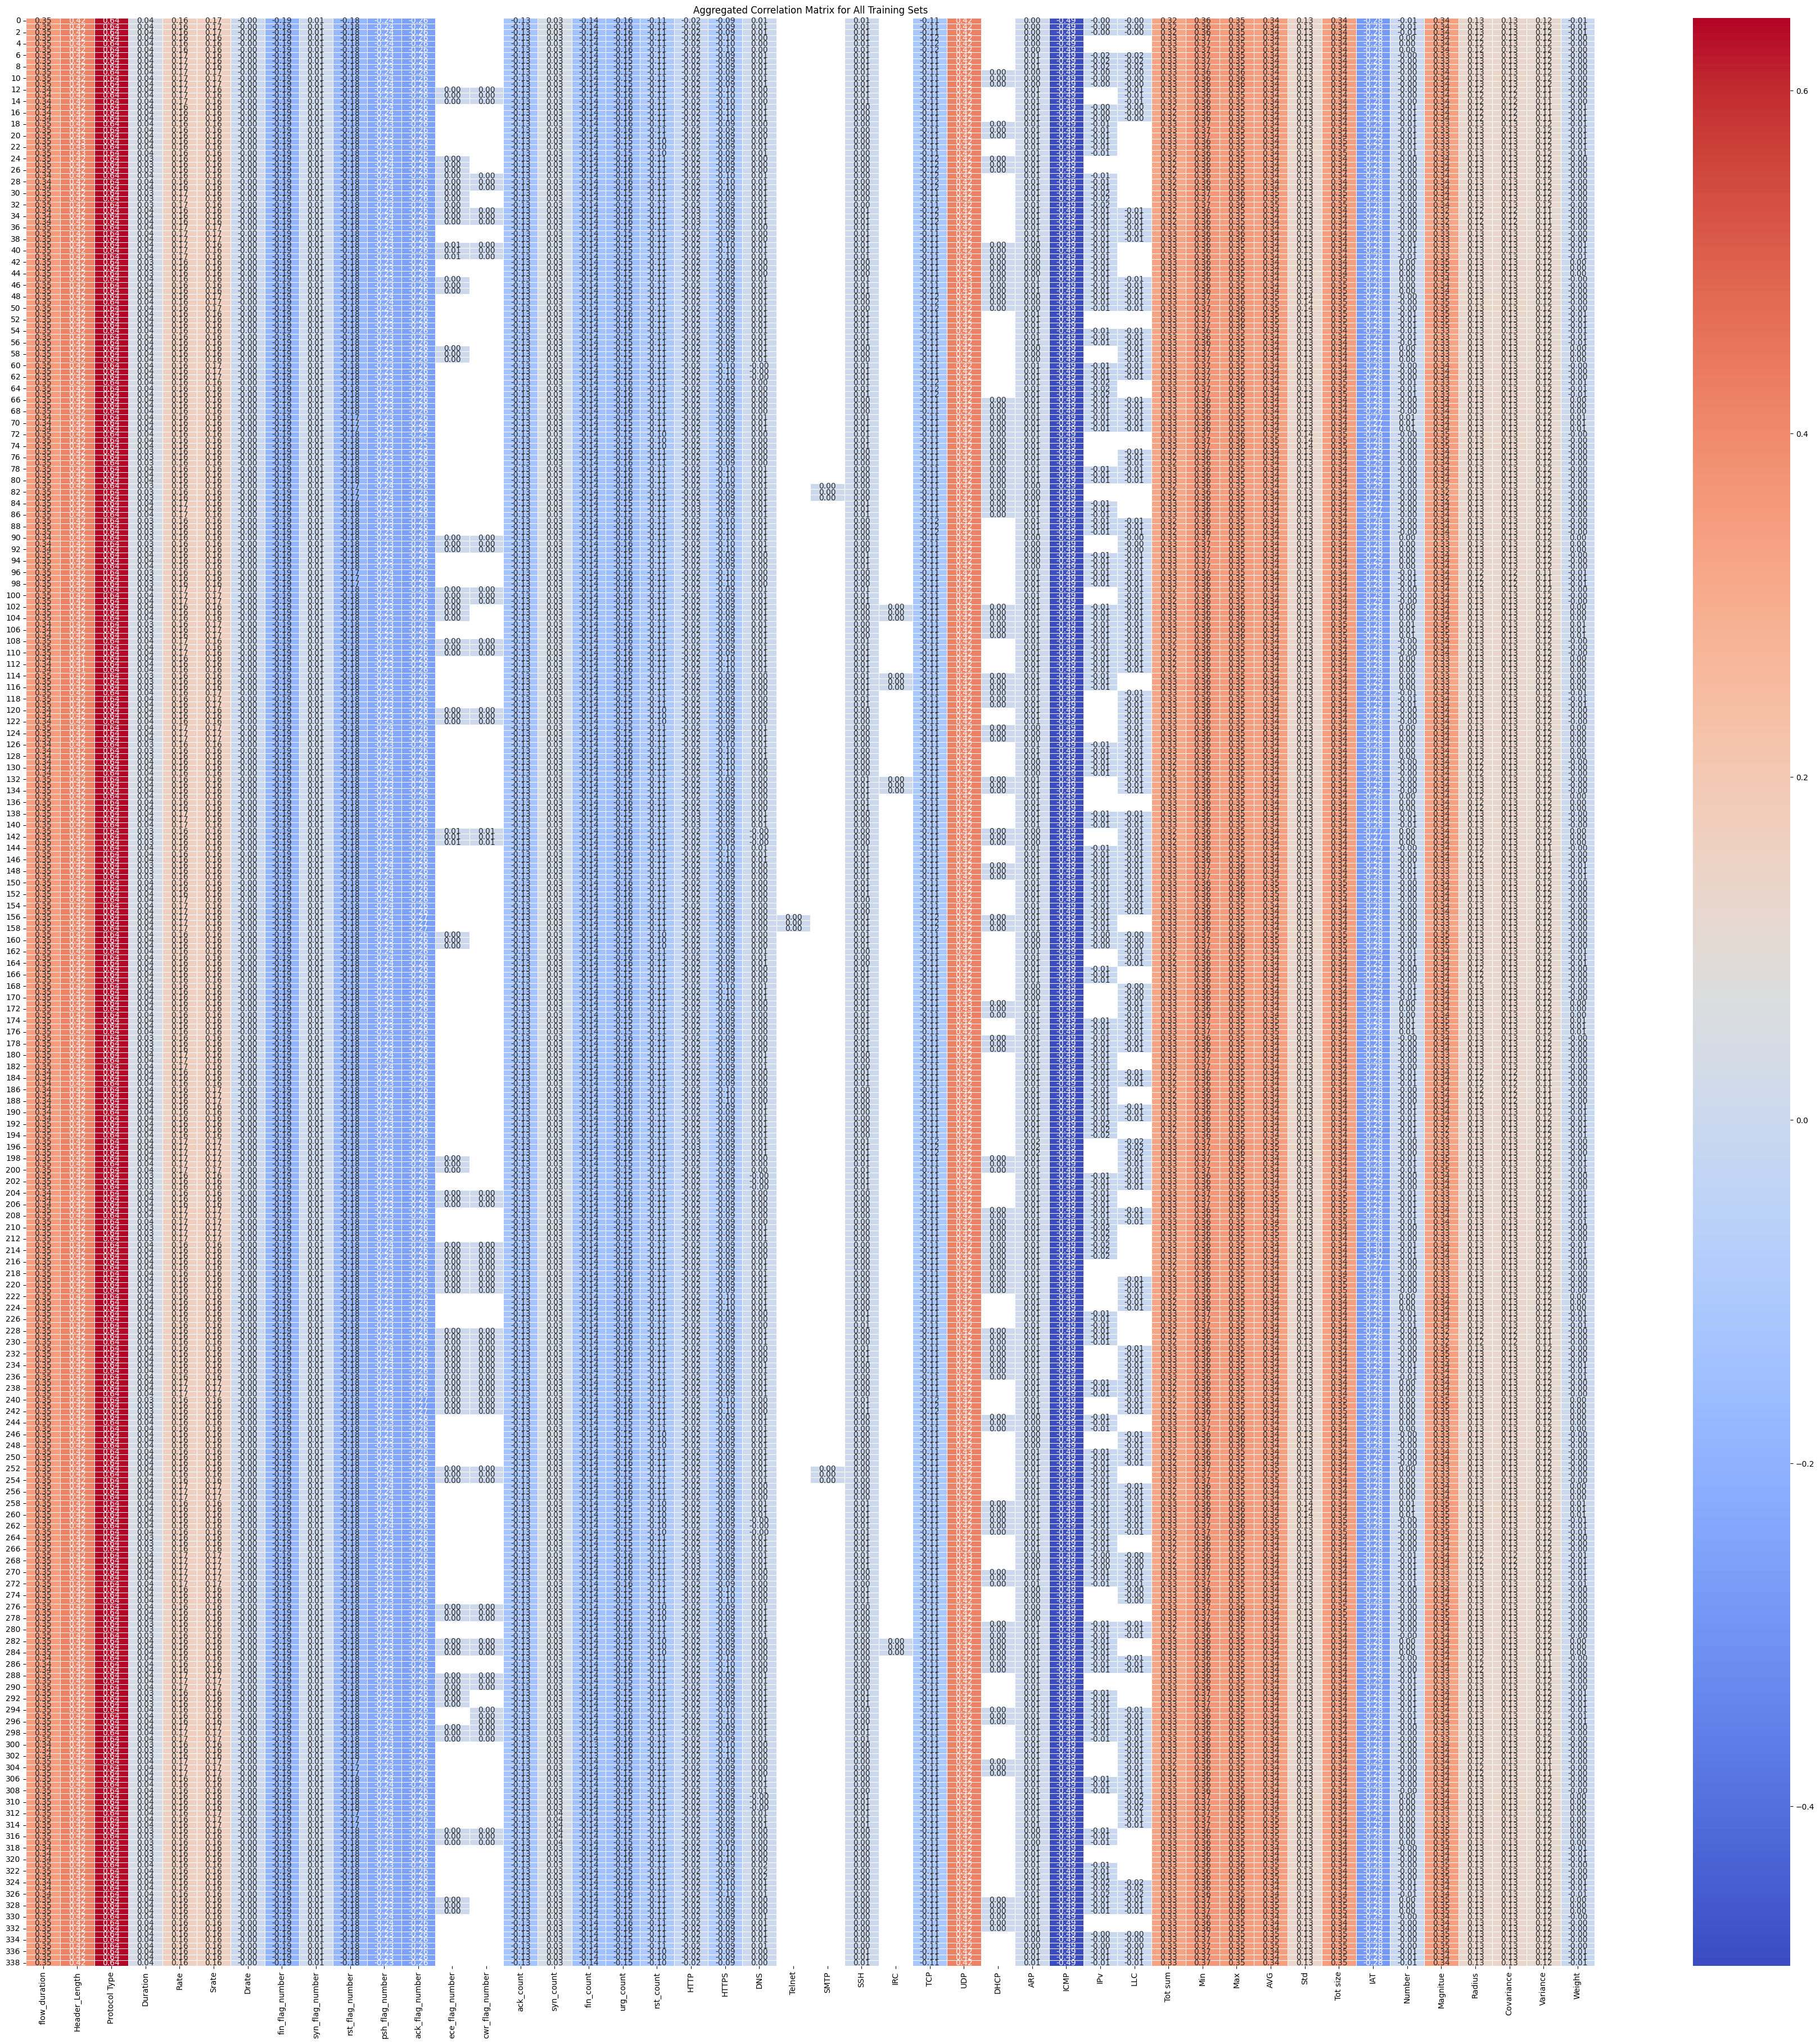

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(45, 45))
sns.heatmap(correlation_matrices, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
            xticklabels=X_columns)
plt.title("Aggregated Correlation Matrix for All Training Sets")
plt.show()

In [7]:
for i in range(len(ML_models)):
    model = ML_models[i]
    import pickle
    with open('/kaggle/working/'+ML_names[i]+'_34classes.pkl', 'wb') as f:
        pickle.dump(model, f)

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
y_test = []
y_pred_proba=[]
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.fit_transform(d_test[X_columns])
    y_test += list(d_test[y_column].values)
    
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        y_pred_proba += list(model.predict_proba(d_test[X_columns])[::,1])
        preds[i] = preds[i] + y_pred
        del y_pred
    del d_test

100%|██████████| 56/56 [20:52<00:00, 22.36s/it]


In [9]:
original_labels=['DDoS-RSTFINFlood','DDoS-PSHACK_Flood','DDoS-SYN_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood','DDoS-ICMP_Flood',
'DDoS-SynonymousIP_Flood','DDoS-ACK_Fragmentation','DDoS-UDP_Fragmentation','DDoS-ICMP_Fragmentation',
'DDoS-SlowLoris','DDoS-HTTP_Flood','DoS-UDP_Flood','DoS-SYN_Flood','DoS-TCP_Flood','DoS-HTTP_Flood','Mirai-greeth_flood','Mirai-greip_flood','Mirai-udpplain',
'Recon-PingSweep','Recon-OSScan','Recon-PortScan','VulnerabilityScan',
'Recon-HostDiscovery',
'DNS_Spoofing',
'MITM-ArpSpoofing',
'BenignTraffic',
'BrowserHijacking',
'Backdoor_Malware',
'XSS',
'Uploading_Attack',
'SqlInjection',
'CommandInjection',
'DictionaryBruteForce']

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
for k,v in preds.items():
    y_pred = v
    label_encoder.fit(original_labels)
    y_pred = label_encoder.inverse_transform(y_pred)
    print(f"\nConfusion Matrix for {ML_names[i]}:\n")
    print(confusion_matrix(y_test, y_pred))
    print("transfered")    
    print(f"{ML_names[k]}")
    print(classification_report(y_test,y_pred))
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))


Confusion Matrix for XG BOOST:

[[     0    844      0 ...      0      9      0]
 [     0 365247      0 ...      0   1482      0]
 [     0   1632      0 ...      0     13      0]
 ...
 [     0    327      0 ...      0      8      0]
 [     0   8105      0 ...      0   2839      0]
 [     0   1055      0 ...      0     11      0]]
transfered
Logistic Regression
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00      1131
          BenignTraffic       0.63      0.94      0.75    387031
       BrowserHijacking       0.00      0.00      0.00      2041
       CommandInjection       0.00      0.00      0.00      1863
 DDoS-ACK_Fragmentation       0.72      0.92      0.81    100231
        DDoS-HTTP_Flood       0.78      0.62      0.69     10131
        DDoS-ICMP_Flood       1.00      1.00      1.00   2537902
DDoS-ICMP_Fragmentation       0.95      0.97      0.96    160098
      DDoS-PSHACK_Flood       1.00      1.00      